In [1]:
import torch
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

# data load frameworks
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit

# models frameworks
import timm
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
from torchvision.models import vgg11, vgg13, vgg16
from torchvision.models import densenet121, densenet169
from torchvision.models import inception_v3
from torchinfo import summary
from torch import nn, optim

# metric frameworks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initial Set

In [2]:
torch.__version__

'1.8.0.dev20201207+cu101'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [4]:
!nvidia-smi

Wed Sep 14 04:06:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   41C    P0    66W / 300W |  12083MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
class Config:
    seed = 777
    packages = 'torchvision'      # torchvision , timm
    model_name = 'densenet121'
    use_fold = True
    fold_num = 5
    batch_size = 30
    n_classes = 3
    lr = 0.001
    train_epoch = 30
    path_train_dataset = './dataset/busi/train'
    path_test_dataset = './dataset/busi/test'
    path_dataset = './dataset/busi/all'
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
config = Config()
seed_everything(config.seed)

# Dataset

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

inception 오류, 왜 299면 되는지도 설명할 수 있어야 하고
normalization 왜 이렇게 하는지 설명 가능해야 함, imagenet normalization도 사용 가능

In [6]:
class BUSI_Dataset(Dataset):
    def __init__(self, dir=str):
        self.dir = dir
        tr = [transforms.ToPILImage(), transforms.Resize([224,224]), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
        self.transform = transforms.Compose(tr)
        self.img_list = []
        self.label_list = []
        self.name_list = []
        for (root, dirs, files) in os.walk(self.dir):
            if not files:
                pass
            else:
                for file in files:
                    self.name_list.append(file)
                    file_name = os.path.join(root,file)
                    self.img_list.append(file_name)
                    if 'normal' in file_name:
                        self.label_list.append(0)
                    elif 'benign' in file_name:
                        self.label_list.append(1)
                    else:
                        self.label_list.append(2)
                    
    def __getitem__(self,idx):
        img = cv2.imread(self.img_list[idx])
        image = self.transform(img)
        label = self.label_list[idx]
        return image, label
    
    def __len__(self):
        return len(self.img_list)
    
    def name(self):
        return np.array(self.name_list)
    
    def indices(self):
        return np.array([i for i in range(len(self.img_list))])
    
    def labels(self):
        return np.array(self.label_list)

In [7]:
if config.use_fold == True:
    dataset = BUSI_Dataset(config.path_dataset)
else:
    trainset = BUSI_Dataset(config.path_train_dataset)
    testset = BUSI_Dataset(config.path_test_dataset)
    dataset = trainset + testset

### - K-fold

https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py <br>
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation <br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold <br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py <br>
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md <br>
https://intrepidgeeks.com/tutorial/implementing-kfold-cross-validation-in-pythorch <br>
https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f <br>
https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/

In [8]:
kfold = StratifiedKFold(n_splits=config.fold_num)

### - dataset length

In [9]:
print(f'data set : {len(dataset)}')

data set : 780


### - sample data

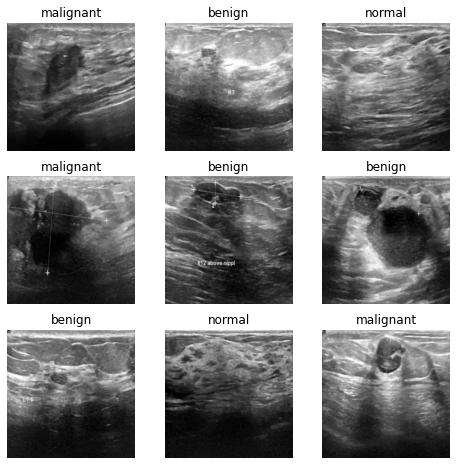

In [10]:
labels_map = {
    0: 'normal',
    1: 'benign',
    2: 'malignant'
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img[0,:,:], cmap="gray")
plt.show()

# model

In [11]:
if Config.packages == 'timm':
    if config.model_name == 'resnet18':
        model = timm.create_model('resnet18', pretrained=True, num_classes=config.n_classes)
    elif config.model_name == 'densenet121':
        model = timm.create_model('densenet121', pretrained=True, num_classes=config.n_classes)
    elif config.model_name == 'inception_v3':
        model = timm.create_model('inception_v3', pretrained=True, num_classes=config.n_classes)
    elif config.model_name == 'inception_resnet_v2':
        model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=config.n_classes)
    elif config.model_name == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=config.n_classes)
    elif config.model_name == 'vit_base_patch16_224':
        model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=config.n_classes)
elif config.packages == 'torchvision':
    if config.model_name == 'resnet18':
        net = resnet18(num_classes=1000, pretrained=True)
    elif config.model_name == 'resnet34':
        net = resnet34(num_classes=1000, pretrained=True)
    elif config.model_name == 'resnet50':
        net = resnet50(num_classes=3, pretrained=False)
    elif config.model_name == 'resnet101':
        net = resnet101(num_classes=1000, pretrained=True)
    elif config.model_name == 'resnet152':
        net = resnet152(num_classes=1000, pretrained=True)
    elif config.model_name == 'vgg11':
        net = vgg11(num_classes=1000, pretrained=True)
    elif config.model_name == 'vgg13':
        net = vgg13(num_classes=1000, pretrained=True)
    elif config.model_name == 'vgg16':
        net = vgg16(num_classes=1000, pretrained=True)
    elif config.model_name == 'densenet121':
        net = densenet121(num_classes=1000, pretrained=True)
    elif config.model_name == 'densenet169':
        net = densenet169(num_classes=1000, pretrained=True)
    elif config.model_name == 'inception_v3':
        net = inception_v3(num_classes=1000, pretrained=True, aux_logits=False)
    model = nn.Sequential(net, nn.Linear(1000, config.n_classes))

In [12]:
if config.packages != 'torchvision' and config.model_name != 'inception_v3':
    summary(model)

## Metric

### - Accuracy

In [13]:
def accuracy(correct, total):
    print('=' * 100)
    print(f'Accuracy of the network on the test images: {100 * correct / total} %')
    print('=' * 100 + '\n')

### - ROC curve & AUC

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multiclass-problem

In [14]:
def roc_curve_auc(outputs, labels, n_class):
    fpr, tpr = dict(), dict() 
    roc_auc, roc_auc_scores = dict(), dict()
    np_outputs, np_labels = np.array(outputs), np.array(labels)
    
    # roc curve, auc of each class
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(np_labels==i, np_outputs[:,i])
        roc_auc_scores[i] = roc_auc_score(np_labels==i, np_outputs[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # micro average
    fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(np_labels, classes=[0,1,2]).ravel(), np_outputs.ravel())     # 
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # macro average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))  # First aggregate all false positive rates
    mean_tpr = np.zeros_like(all_fpr)                                      # Then interpolate all ROC curves at this points
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_class                                                    # Finally average it and compute AUC
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, roc_auc

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.figure(figsize=(7,7))
    lw = 2
    class_name = ['normal', 'benign', 'malignant']
    colors = ["aqua", "darkorange", "cornflowerblue", "purple", "red"]

    for i, color in zip(range(config.n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label="ROC curve of class : {0} (area = {1:0.2f})".format(class_name[i], roc_auc[i]))

    plt.plot(fpr["micro"], tpr["micro"], color=colors[-1], linestyle=":", lw=lw+3, label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]))
    plt.plot(fpr["macro"], tpr["macro"], color=colors[-2], linestyle=":", lw=lw+3, label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic curve", fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

### - classification reports

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [15]:
def reports(label, predict):
    print("\n******************************************************")
    print('Classfication Reports'.center(54))
    print("******************************************************")
    print(classification_report(label, predict, target_names=['normal', 'benign', 'malignant']))
    print("******************************************************")

### - confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.plot <br>
https://medium.com/@djin31/how-to-plot-wholesome-confusion-matrix-40134fd402a8

In [16]:
def cm_display(label, predict):
    cm = confusion_matrix(label, predict)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'benign', 'malignant'])
    fig2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['normal', 'benign', 'malignant'])
    fig1.plot()
    plt.title("Confusion Matrix", fontsize=16)
    fig2.plot()
    plt.title("Normalized Confusion Matrix", fontsize=16)
    plt.show()
#    ConfusionMatrixDisplay.from_predictions(label, predict, normalize='all', display_labels=['normal', 'benign', 'malignant'])
#    plt.show()

# train

In [17]:
def training(model, trainloader, criterion, optimizer, device):
    train_n, train_cor, train_loss = 0, 0, 0
    for i, data in enumerate(trainloader):
        model.train()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_cor += torch.sum(outputs.argmax(1).eq(labels))
        train_n += len(labels)
        
        if i % 10 == 0:
            train_acc = int(train_cor)/train_n
            print(f'Epoch : {epoch+1}/{config.train_epoch} | train loss : {train_loss / 10:.3f} | train acc : {train_acc*100}')
            train_loss = 0.0
        
        return train_loss, train_cor, train_n

# test

In [18]:
def testing(model, testloader, criterion, device):
    correct, total = 0, 0
    output_list, predict_list, labels_list = [], [], []

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            output_list.extend(outputs.to('cpu').tolist())
            predict_list.extend(predicted.to('cpu').tolist())
            labels_list.extend(labels.to('cpu').tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        ###########
        # Metrics #
        ###########
        ## accuracy
        accuracy(correct, total)
        ## roc curve & auc
        fpr, tpr, roc_auc = roc_curve_auc(output_list, labels_list, config.n_classes)
        plot_roc_auc(fpr, tpr, roc_auc)
        ## reports
        reports(labels_list, predict_list)
        ## confusion matrix
        cm_display(labels_list, predict_list)
    
    return correct, total, output_list, predict_list, labels_list

# Main

subsetrandomsampler?

----------------------------------------------------------------------------------------------------
fold = 1 
 test indices = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87 437 438
 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456
 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474
 475 476 477 478 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672]
----------------------------------------------------------------------------------------------------
Epoch : 1/30 | train loss : 0.139 | train acc : 40.0
Epoch : 2/30 | train loss : 0.209 | train acc : 43.333333333333336
Epoch : 3/30 | tra

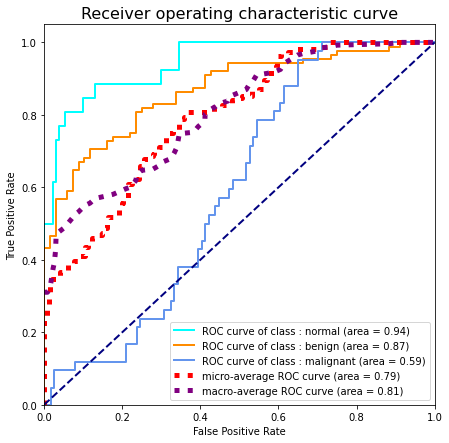


******************************************************
                Classfication Reports                 
******************************************************
              precision    recall  f1-score   support

      normal       1.00      0.15      0.27        26
      benign       0.74      0.84      0.79        88
   malignant       0.58      0.71      0.64        42

    accuracy                           0.69       156
   macro avg       0.77      0.57      0.56       156
weighted avg       0.74      0.69      0.66       156

******************************************************


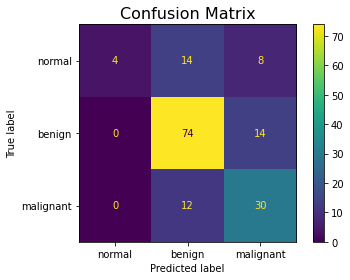

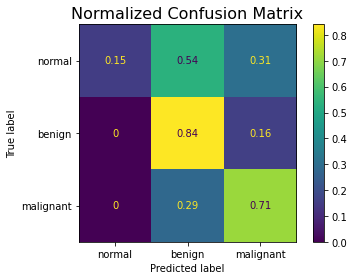

----------------------------------------------------------------------------------------------------
fold = 2 
 test indices = [ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 673 674 675 676 677 678 679 680 681 682 683 684 685 686
 687 688 689 690 691 692 693 694 695 696 697 698]
----------------------------------------------------------------------------------------------------
Epoch : 1/30 | train loss : 0.065 | train acc : 76.66666666666667
Epoch : 2/30 | train loss : 0.044 | train acc : 76.66666666666667
Epoch 

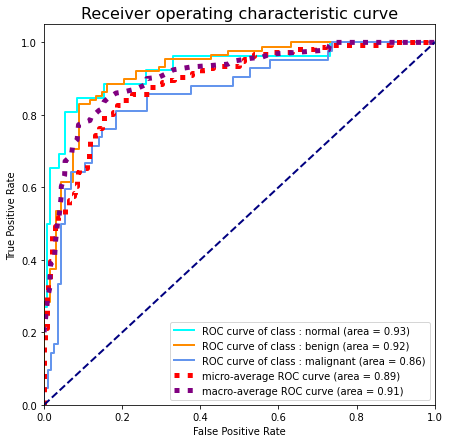


******************************************************
                Classfication Reports                 
******************************************************
              precision    recall  f1-score   support

      normal       0.92      0.42      0.58        26
      benign       0.70      0.98      0.82        88
   malignant       0.86      0.45      0.59        42

    accuracy                           0.74       156
   macro avg       0.83      0.62      0.66       156
weighted avg       0.78      0.74      0.72       156

******************************************************


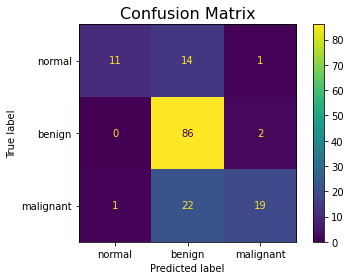

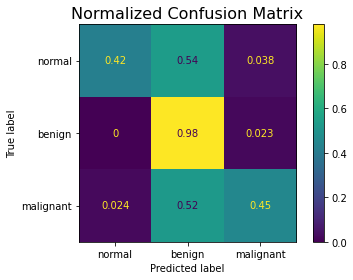

----------------------------------------------------------------------------------------------------
fold = 3 
 test indices = [176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 521 522 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719 720 721 722 723 724 725]
----------------------------------------------------------------------------------------------------
Epoch : 1/30 | train loss : 0.089 | train acc : 83.33333333333334
Epoch : 2/30 | train loss : 0.026 | train acc : 93.33333333333333
Epoch 

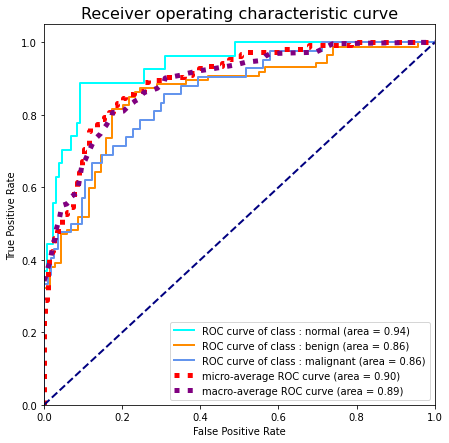


******************************************************
                Classfication Reports                 
******************************************************
              precision    recall  f1-score   support

      normal       0.66      0.78      0.71        27
      benign       0.84      0.84      0.84        87
   malignant       0.81      0.71      0.76        42

    accuracy                           0.79       156
   macro avg       0.77      0.78      0.77       156
weighted avg       0.80      0.79      0.80       156

******************************************************


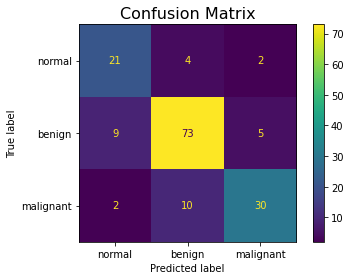

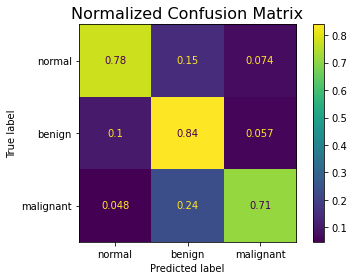

----------------------------------------------------------------------------------------------------
fold = 4 
 test indices = [263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 601
 602 603 604 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740
 741 742 743 744 745 746 747 748 749 750 751 752]
----------------------------------------------------------------------------------------------------
Epoch : 1/30 | train loss : 0.024 | train acc : 93.33333333333333
Epoch : 2/30 | train loss : 0.017 | train acc : 93.33333333333333
Epoch 

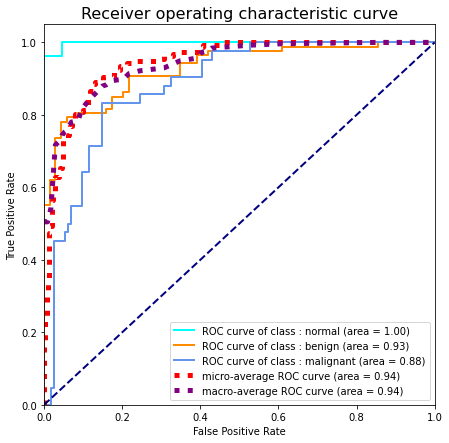


******************************************************
                Classfication Reports                 
******************************************************
              precision    recall  f1-score   support

      normal       0.96      0.93      0.94        27
      benign       0.81      0.95      0.87        87
   malignant       0.85      0.55      0.67        42

    accuracy                           0.84       156
   macro avg       0.87      0.81      0.83       156
weighted avg       0.85      0.84      0.83       156

******************************************************


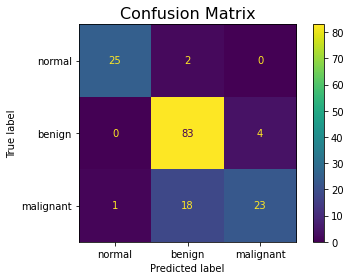

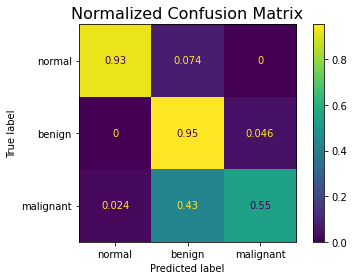

----------------------------------------------------------------------------------------------------
fold = 5 
 test indices = [350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385
 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403
 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767
 768 769 770 771 772 773 774 775 776 777 778 779]
----------------------------------------------------------------------------------------------------
Epoch : 1/30 | train loss : 0.025 | train acc : 93.33333333333333
Epoch : 2/30 | train loss : 0.039 | train acc : 80.0
Epoch : 3/30 | trai

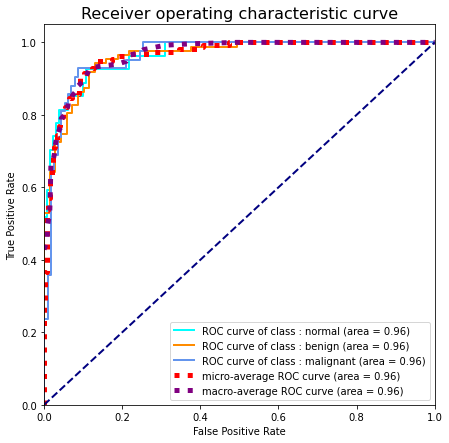


******************************************************
                Classfication Reports                 
******************************************************
              precision    recall  f1-score   support

      normal       0.78      0.93      0.85        27
      benign       0.94      0.85      0.89        87
   malignant       0.84      0.90      0.87        42

    accuracy                           0.88       156
   macro avg       0.85      0.89      0.87       156
weighted avg       0.88      0.88      0.88       156

******************************************************


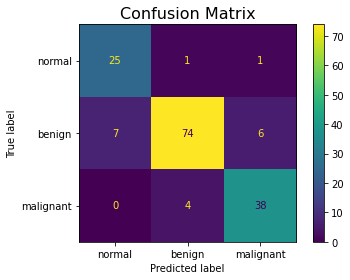

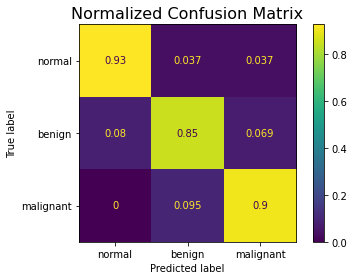

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
model.to(device)                       # if device == 'cuda' 이게 안되네..

total_correct,  = []
if config.use_fold == True:
    for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset.indices(),dataset.labels())):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
        trainloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=test_subsampler)
        print('='*100)
        print(f'fold = {fold + 1} \n test indices = {(test_indices)}')
        print('='*100)
        
        for epoch in range(config.train_epoch):
            
            train_loss, train_cor, train_n = training(model, trainloader, criterion, optimizer, device)
        
        correct, total, output_list, predict_list, labels_list = testing(model, testloader, criterion, device)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    
    for epoch in range(config.train_epoch):
        train_loss, train_cor, train_n = training(model, trainloader, criterion, optimizer, device)
        
    correct, total, output_list, predict_list, labels_list = testing(model, testloader, criterion, device)